# Detecting Malaria cells using CNN and TF 2.0
### Tutorial: following https://www.kaggle.com/kushal1996/detecting-malaria-cnn


#### Steps
1. import libraries
2. load data
3. preprocess data
4. data augmentation
5. plot images: infected/uninfected to see difference
6. split data: train, evaluation and test set
7. create cnn func
8. wrap it with tf estimator func
9. training data on train data
10. evaluate with evaluation data
11. predict with test dat
12. plot predicted iaages and respective true/predicted value


## 1. Import Libraries

In [13]:
from __future__ import absolute_import, division, print_function
# linear algebra
import numpy as np
# dat structures and data analysis tools, data processing, csv file I/O
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# computer vision library, image processing
import cv2
import matplotlib.pyplot as plt
# statistical data visualization
import seaborn as sns
# Python Image Libary
# Provides support for opening, editing and savin many different data formats
from PIL import Image
# use os deppendent functionality, interface with underlying os
import os
print(os.listdir("data/cell_images"))


['Parasitized', 'Uninfected']


## 2. Load Data

In [9]:
parasitized = os.listdir("data/cell_images/Parasitized")
uninfected = os.listdir("data/cell_images/Uninfected")

print(len(parasitized))
print(len(uninfected))

13780
13780


## 3. Preprocess Data

In [3]:
def preprocessData(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    #Creates an image memory from an object exporting the array interface 
    image_array = Image.fromarray(image, 'RGB')
    resize_img = image_array.resize((50,50))
    return resize_img

## 4. Data Augmentation

In [4]:
def augmentData(image, label):
    img_data = []
    img_labels = []
    rotated45 = image.rotate(45)
    rotated75 = image.rotate(75)
    blur = cv2.blur(np.array(image), (10, 10))
    
    img_data.append(np.array(image))
    img_data.append(np.array(rotated45))
    img_data.append(np.array(rotated75))
    img_data.append(np.array(blur))
    # creates labels 1 = parasitized, 0 = uninfected
    img_labels.append(label)
    img_labels.append(label)
    img_labels.append(label)
    img_labels.append(label)
    return img_data, img_labels

## Generate all data and labels

In [6]:
# this is where our data will be stored
data_pa=[]
# this is where the labels corresponding to the data will be stored
labels_p=[]

for p in parasitized:
    path = "data/cell_images/Parasitized/" + p
    proc_img = preprocessData(path)
    # thumb.db in folder causes error
    if proc_img is None:
        continue 
    data_p, label_p = augmentData(proc_img, 1)
    data_pa.extend(data_p)
    labels_p.extend(label_p)

print(len(data_pa))
print(len(labels_p))



55116
55116


In [7]:
# this is where our data will be stored
data_un=[]
# this is where the labels corresponding to the data will be stored
labels_u=[]

for p in uninfected:
    path = "data/cell_images/Uninfected/" + p
    proc_img = preprocessData(path)
    # thumb.db in folder causes error
    if proc_img is None:
        continue 
    data_p, label_p = augmentData(proc_img, 0)
    data_un.extend(data_p)
    labels_u.extend(label_p)

print(len(data_un))
print(len(labels_u))

55116
55116


In [7]:
data=data_pa+data_un
labels=labels_p+labels_u
# Checking whether we have the same number of images and labels
print('Data: {} , Labels: {}'.format(len(data), len(labels)))

Data: 110232 , Labels: 110232


In [8]:
cells = np.array(data)
labels = np.array(labels)

# save array to binary file
np.save('Cells', cells)
np.save('Labels', labels)

# A simple format for saving numpy arrays to disk with the full information about them.
# The .npy format is the standard binary file format in NumPy for persisting a single arbitrary NumPy array on disk.
# The format stores all of the shape and dtype information necessary to reconstruct the array correctly even on
# another machine with a different architecture. The format is designed to be as simple as possible while achieving
# its limited goals.

In [9]:
print('Cells : {} | labels : {}'.format(cells.shape, labels.shape))

Cells : (110232, 50, 50, 3) | labels : (110232,)


## 5. Plot Images: infected/uninfected to see difference

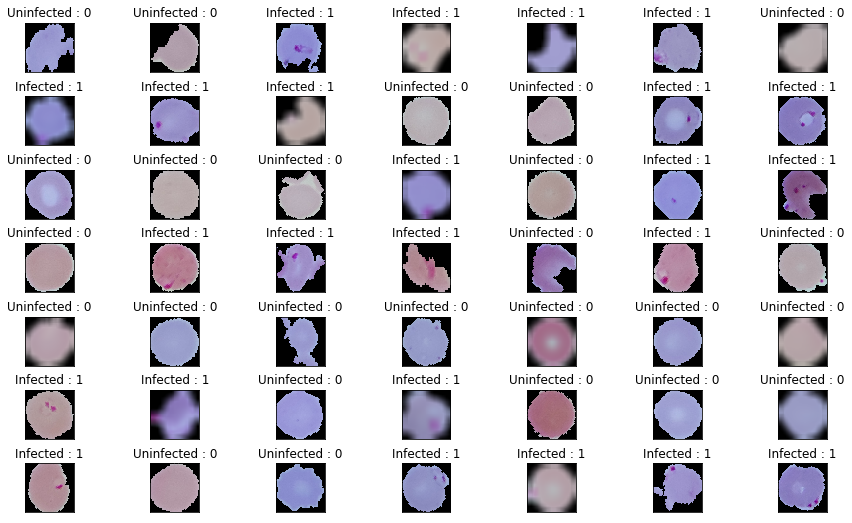

In [10]:
plt.figure(1, figsize=(15,9))
n=0
for i in range(49):
    n +=1
    r = np.random.randint(0, cells.shape[0], 1)
    plt.subplot(7,7,n)
    plt.subplots_adjust(hspace=0.5, wspace= 0.5)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Infected' if labels[r[0]] == 1 else 'Uninfected', labels[r[0]]))
    # Disable xticks:
    plt.xticks([]), plt.yticks([])
plt.show()

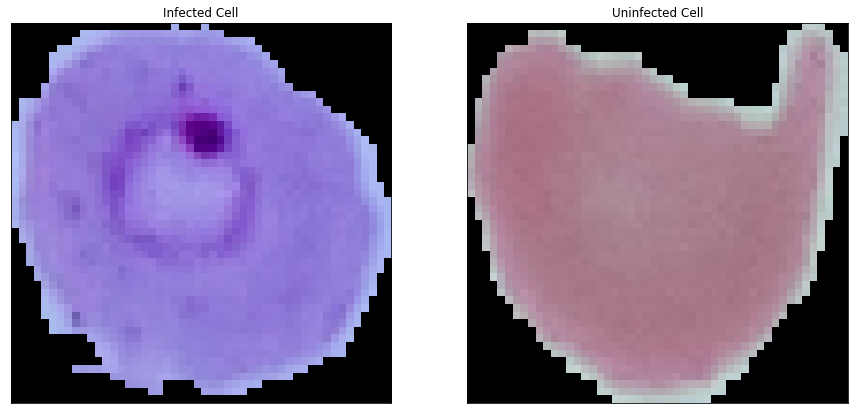

In [11]:
plt.figure(1, figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(cells[0])
plt.title('Infected Cell')
plt.xticks([]), plt.yticks([])

plt.figure(1, figsize=(15,7))
plt.subplot(1,2,2)
plt.imshow(cells[60000])
plt.title('Uninfected Cell')
plt.xticks([]), plt.yticks([])

plt.show()

## 6. Split Data: train, evaluation and test set

In [12]:
# shuffle data

# Return evenly spaced values within a given interval(Here: 0-110231)
# For integer arguments the function is equivalent to the Python built-in range function, but returns an
# ndarray rather than a list.
n = np.arange(cells.shape[0])

# shuffles all the values in n
np.random.shuffle(n)
# rearanges/shuffles order of cells
cells = cells[n]
# rearanges/shuffles order of labels
labels = labels[n]

In [13]:
# Copy of the array, cast to a specified type.
cells = cells.astype(np.float32)
labels = labels.astype(np.int32)
# Pixel values of cells range from 0 to 255
# To scale them to range from 0 to 1 -> divide by 255
cells = cells/255.0

In [14]:
# Split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
# test_size: represent the proportion of the dataset to include in the test split
# random_state: random_state is the random number generator; If None, the random number generator is the RandomState 
# instance used by np.random. -> optional (default:none)
train_x, x, train_y, y = train_test_split(cells, labels,
                                         test_size = 0.33,
                                         random_state = 111)

# split the above "test-set" (= x & y) into test and evaluation data
eval_x, test_x, eval_y, test_y = train_test_split(x, y,
                                                 test_size = 0.5,
                                                 random_state = 111)

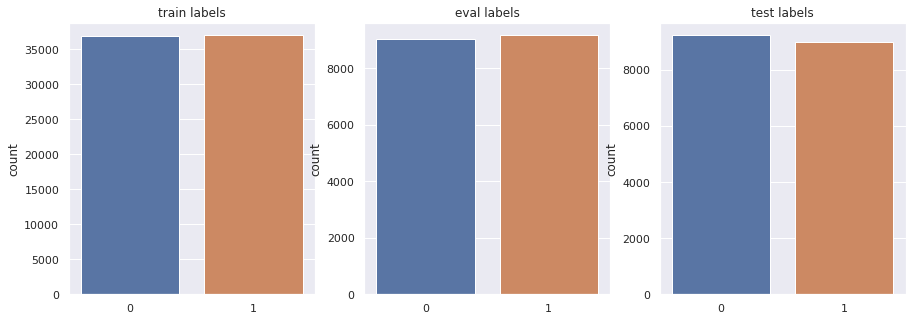

In [15]:
# Plot split labels
# Visualize repartition of data
plt.figure(1, figsize=(15,5))
n=0
for categorie,label_name in zip([train_y, eval_y, test_y], ['train labels', 'eval labels', 'test labels']):
    n +=1
    sns.set(style='darkgrid')
    plt.subplot(1,3,n)
    # show the counts of observations in each categorical bin using bars.
    # x: "class" that is to be plotted
    sns.countplot(x=categorie)
    plt.title(label_name)
plt.show()

In [16]:
print('train data shape : {}\n eval data shape : {}\n test data shape : {}'.format(train_x.shape, eval_x.shape,
                                                                                 test_x.shape))
# Check if no data is lost: should be 110232 in total
#print(train_x.shape[0] + eval_x.shape[0] + test_x.shape[0])
#print(train_y.shape[0] + eval_y.shape[0] + test_y.shape[0])

train data shape : (73855, 50, 50, 3)
 eval data shape : (18188, 50, 50, 3)
 test data shape : (18189, 50, 50, 3)


## 7. Create CNN func

In [17]:
# Clears the default graph stack and resets the global default graph.
#tf.reset_default_graph()

def convLayer(inputs, filters, kernel_size, padding='same', activation = tf.nn.relu):
    conv = tf.layers.conv2d(
        inputs=inputs,
        filters= filters,
        kernel_size=kernel_size,
        padding=padding,
        activation=activation)
    return conv

def poolLayer(inputs, pool_size, strides, padding=None):
    pool=tf.layers.max_pooling2d(
        inputs=inputs,
        pool_size=pool_size,
        strides=strides,
        padding=padding)
    return pool

def fcLayer(inputs, units, activation=tf.nn.relu):
    fc=tf.layers.dense(
        inputs=inputs,
        units=units,
        activation=activation)
    
def cnn_model_fn(features, labels, mode):
    input_layers = tf.reshape(features['x'], [-1, 50, 50, 3])
    conv1 = convLayer(input_layers, 50, [7,7])
    conv2 = convLayer(conv1, 90, [3,3], padding='valid')
    conv3 = convLayer(conv2, 10, [5,5])
    pool1 = poolLayer(conv3, [2,2], 2)
    conv4 = convLayer(pool1, 5, [3,3])
    pool2 = poolLayer(conv4, [2,2], 2, padding='same')
    pool2_flatten = tf.layers.flatten(pool2)
    fc1 = fcLayer(pool2_flatten, 2000)
    fc2 = fcLayer(fc1, 1000)
    fc3 = fcLayer(fc2, 500)
    # The final layer in our neural network is the logits layer, which will return the raw values for our predictions. 
    logits = tf.layers.dense(inputs=fc3, units=2)



In [19]:
model = models.Sequential()
model.add(layers.Conv2D(50, (7,7), activation='relu',padding='same', input_shape=(50,50,3)))
model.add(layers.Conv2D(90, (3,3), activation='relu',padding='valid'))
model.add(layers.Conv2D(10, (5,5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2), 2))
model.add(layers.Conv2D(5, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2), 2, padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(2000, activation='relu'))
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 50)        7400      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 90)        40590     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 10)        22510     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 10)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 5)         455       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 5)         0         
_________________________________________________________________
flatten (Flatten)            (None, 720)               0

In [21]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.fit(train_x, train_y, epochs=5)

W0606 23:41:31.977894 139662878922560 deprecation.py:323] From /home/laila/.python-env/default/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 73855 samples
Epoch 1/5
73855/73855 [==============================] - 1625s 22ms/sample - loss: 0.3837 - accuracy: 0.8080
Epoch 2/5
73855/73855 [==============================] - 1657s 22ms/sample - loss: 0.1870 - accuracy: 0.9339
Epoch 3/5
73855/73855 [==============================] - 1581s 21ms/sample - loss: 0.1583 - accuracy: 0.9444
Epoch 4/5
73855/73855 [==============================] - 1518s 21ms/sample - loss: 0.1448 - accuracy: 0.9499
Epoch 5/5
73855/73855 [==============================] - 1527s 21ms/sample - loss: 0.1300 - accuracy: 0.9546


In [22]:
# Save entire model to a HDF5 file
model.save('my_model.h5')


- iml: mirror
- tf:gpu
- classcial, modern architecture